# Kernelized Linear Regression



In [1]:
% matplotlib inline
% reload_ext autoreload
% load_ext autoreload
% autoreload 2 

import numpy as np
import matplotlib.pyplot as plt
from util import gradient_descent
import plot_helpers
import IPython 

import ipywidgets
from ipywidgets import interact, interactive, interact_manual

import pylab
pylab.rcParams['figure.figsize'] = (10, 5)

from kernels import LinearKernel, PolynomialKernel, LaplacianKernel, GaussianKernel, PeriodicKernel
from kernels import SumKernel
from regularizers import L2Regularizer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


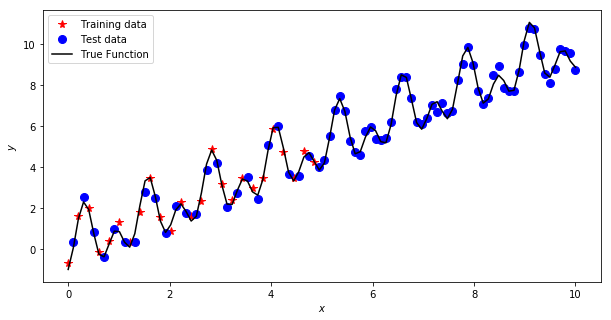

In [2]:
num_points = 100
xmin = 0
xmax = 10
noise = 0.2
X = np.reshape(np.linspace(xmin, xmax, num_points), [-1, 1])  # create 1-D input data
F = X + np.sin(X * 5) - np.cos(X * 10)  # true functional response
Y = F + noise * np.random.randn(num_points, 1)  # generate noisy labels

# Training Data
training_idx = np.arange(0, 50, 2)
Xtr = X[training_idx, :]
Ytr = Y[training_idx]

# Test Data
test_idx = np.setdiff1d(np.arange(0, num_points, 1), training_idx)
Xtest = X[test_idx, :]
Ytest = Y[test_idx]

fig = plt.subplot(111)
opt = {'marker': 'r*', 'label': 'Training data'}
plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
opt = {'marker': 'bo', 'label': 'Test data'}
plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)
opt = {'marker': 'k-', 'label': 'True Function', 'x_label': '$x$', 'y_label': '$y$', 'legend': True}
plot_helpers.plot_data(X, F, fig=fig, options=opt)


In [3]:
def kernel_regression(kernel, reg, deg, kernel_width):
    reg = np.power(10., reg)
    if kernel == 'Linear':
        regressor = LinearKernel(Xtr, Ytr, reg=reg)
    elif kernel == 'Polynomial':
        regressor = PolynomialKernel(Xtr, Ytr, deg=deg, reg=reg)
    elif kernel == 'Laplacian':
        regressor = LaplacianKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    elif kernel == 'Gaussian':
        regressor = GaussianKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    elif kernel == 'Periodic':
        regressor = PeriodicKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    elif kernel == 'Poly + Gaussian':
        regressor = SumKernel([GaussianKernel, PolynomialKernel], Xtr, Ytr, reg=reg, deg=deg, bw=kernel_width)
        # regressor = GaussianPolyKernel(Xtr, Ytr, reg=reg, deg=deg, bw=kernel_width)
    elif kernel == 'Poly + Periodic':
        regressor = SumKernel([PeriodicKernel, PolynomialKernel], Xtr, Ytr, reg=reg, deg=deg, bw=kernel_width)
#         regressor = PeriodicPolyKernel(Xtr, Ytr, reg=reg, deg=deg, bw=kernel_width)

    regressor.calculate_alpha(Ytr)
    ypr = regressor.predict(X)

    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': 'Training data'}
    plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
    opt = {'marker': 'bo', 'label': 'Test data'}
    plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)
    opt = {'marker': 'g-', 'label': kernel + ' Kernel', 'x_label': '$x$', 'y_label': '$y$', 'legend': True}
    plot_helpers.plot_data(X, ypr, fig=fig, options=opt)
    fig.set_xlim([-1, 11])
    fig.set_ylim([-1, 11])

interact(kernel_regression,
         kernel=ipywidgets.RadioButtons(
             options=['Linear', 'Polynomial', 'Laplacian', 'Gaussian', 'Periodic', 'Poly + Gaussian', 'Poly + Periodic'],
             value='Linear',
             description='Kernel type:',
             style={'description_width': 'initial'}),
         reg=ipywidgets.FloatSlider(
             value=-2,
             min=-3,
             max=3,
             step=1e-3,
             readout_format='.3f',
             description='Regularization 10^:',
             style={'description_width': 'initial'},
             continuous_update=False),
         deg = ipywidgets.IntSlider(
             value=1,
             min=1,
             max=10, 
             step=1,
             description='Degree of Polynomial kernel:',
             style={'description_width': 'initial'}),
         kernel_width=ipywidgets.FloatSlider(
             value=0.2,
             min=0.01,
             max=3,
             step=0.01,
             readout_format='.3f',
             description='Kernel Width:',
             style={'description_width': 'initial'},
             continuous_update=False),
         );


interactive(children=(RadioButtons(description='Kernel type:', options=('Linear', 'Polynomial', 'Laplacian', 'Gaussian', 'Periodic', 'Poly + Gaussian', 'Poly + Periodic'), style=DescriptionStyle(description_width='initial'), value='Linear'), FloatSlider(value=-2.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.3f', step=0.001, style=SliderStyle(description_width='initial')), IntSlider(value=1, description='Degree of Polynomial kernel:', max=10, min=1, style=SliderStyle(description_width='initial')), FloatSlider(value=0.2, continuous_update=False, description='Kernel Width:', max=3.0, min=0.01, readout_format='.3f', step=0.01, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

In [4]:
def parameter_variation(kernel, reg=0.05, kernel_width=5):
    if kernel == 'Laplacian':
        regressor = LaplacianKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    elif kernel == 'Gaussian':
        regressor = GaussianKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    elif kernel == 'Periodic':
        regressor = PeriodicKernel(Xtr, Ytr, reg=reg, bw=kernel_width)
    regressor.calculate_alpha(Ytr)
    ypr = regressor.predict(X)
    
    fig = plt.subplot(111)
    opt = {'marker': 'r*', 'label': 'Training data'}
    plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
    opt = {'marker': 'bo', 'label': 'Test data'}
    plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)

    opt = {'marker': 'g-', 'label': 'Gaussian Kernel', 'x_label': '$x$', 'y_label': '$y$', 'legend': True}
    plot_helpers.plot_data(X, ypr, fig=fig, options=opt)


interact(parameter_variation,
         kernel=ipywidgets.RadioButtons(
             options=['Laplacian', 'Gaussian', 'Periodic'],
             value='Gaussian',
             description='Kernel type:',
             style={'description_width': 'initial'}),
         kernel_width=ipywidgets.FloatSlider(
             value=0.2,
             min=0.01,
             max=3,
             step=0.01,
             readout_format='.3f',
             description='Kernel Width:',
             style={'description_width': 'initial'},
             continuous_update=False),
         reg=ipywidgets.FloatSlider(
             value=1e-2,
             min=0,
             max=1,
             step=1e-3,
             readout_format='.3f',
             description='Regularization Coefficient:',
             style={'description_width': 'initial'},
             continuous_update=False)
         );


interactive(children=(RadioButtons(description='Kernel type:', index=1, options=('Laplacian', 'Gaussian', 'Periodic'), style=DescriptionStyle(description_width='initial'), value='Gaussian'), FloatSlider(value=0.01, continuous_update=False, description='Regularization Coefficient:', max=1.0, readout_format='.3f', step=0.001, style=SliderStyle(description_width='initial')), FloatSlider(value=0.2, continuous_update=False, description='Kernel Width:', max=3.0, min=0.01, readout_format='.3f', step=0.01, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

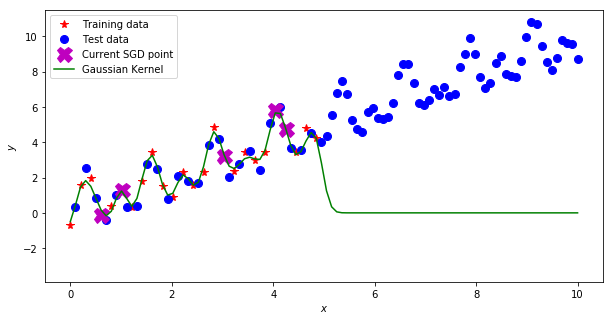

In [5]:
regressor = GaussianKernel(Xtr, Ytr, reg=0.0, bw=0.2)
regularizer = L2Regularizer(0)
alpha0 = np.random.randn(Xtr.shape[0])

opts = {'eta0': 1,
        'n_iter': 50,
        'batch_size': 5,
        'n_samples': Xtr.shape[0],
        'algorithm': 'SGD',
        'learning_rate_scheduling': None
        }
alphas, indexes = gradient_descent(alpha0, regressor, regularizer, opts)

fig = plt.subplot(111)
opt = {'marker': 'r*', 'label': 'Training data'}
plot_helpers.plot_data(Xtr, Ytr, fig=fig, options=opt)
opt = {'marker': 'bo', 'label': 'Test data'}
plot_helpers.plot_data(Xtest, Ytest, fig=fig, options=opt)

opt = {'marker': 'g-', 'label': 'Gaussian Kernel', 'x_label': '$x$', 'y_label': '$y$', 'legend': True, 'sgd_point': True}
plot_helpers.kernelized_regression_progression(X, Xtr, Ytr, alphas, indexes, regressor, fig=fig, options=opt)
